# Comparing Distributions, From Zero to Hero

The problem of comparing distributions often arises in causal inference when we have to **assess the quality of randomization**. 

When we want to assess the causal effect of a policy (or, feature, campaign, drug, ...), the golden standard in causal inference are [**randomized control trials**](https://en.wikipedia.org/wiki/Randomized_controlled_trial), also known in the industry as [**A/B tests**](https://de.wikipedia.org/wiki/A/B-Test). In practice, we select a sample for the study and we randomly split it into a **control** and a **treatment** group, to compare the outcomes between the two groups. The idea is that randomization ensures that only difference between the two groups is the treatment, on average. Therefore, we can attribute the difference in outcomes to the treatment effect alone. 

The **problem** is that, despite randomization, the two groups are never identical. However, sometimes, they are not even "similar". For example, we might have more males in one group, or older people, etc.. (we usually call these characteristics, *covariates* or *control variables*). When it happens, we cannot be certain anymore that the difference in the outcome is only due to the treatment and cannot be attributed to the **inbalanced covariates** instead. Therefore, it is always important, after randomization, to check whether all observed variables are balance across groups and whether there are no systematic differences. Another option, to be certain that certain covariates are balanced, is [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling).

In this blog post, we are going to see different ways to compare two (or more) distributions and assess the magnitude and significance of their difference. We are going to consider two different approaches, **visual** and **statistical**. The two approaches generally trade-off **intuition** with **rigor**: from plots we can quickly assess and explore differences, but it's hard to tell whether these differences are systematic or due to noise.

## The Data

Let's assume we need to perform an **experiment** on a group of individuals and we have **randomized** them into a treatment and control group. We would like them to be **as comparable as possible**, in order to attribute any difference between the two groups to the treatment effect alone. We also have divided the treatment group in different *arms* for testing different treatments.

For this example, I have simulated a dataset of 1000 individuals, for whom we observe a set of characteristics. I import the data generating process `dgp_rnd_assignment()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_rnd_assignment

df = dgp_rnd_assignment().generate_data()
df.head()

,Group,Arm,Gender,Age,Income
0,control,arm 2,0,29.0,3967.16
1,control,arm 4,1,32.0,2927.77
2,treatment,NaN,0,29.0,1642.66
3,control,arm 4,0,25.0,1867.64
4,treatment,NaN,1,32.0,3202.35


We have information on $1000$ individuals, for which we observe `gender`, `age` and `income`. Each individual is assigned either to the treatment or control `group` and treated individuals are distributed across four treatment `arms`.

## Two Groups - Plots

Let's start with the simplest setting: we want to compare the distribution of income across the `treatment` and `control` group. We first explore **visual** approaches and the **statistical** approaches. The advantage of the first is **intuition** while the advantage of the second is **precision**

### Boxplot

A first visual approach is the [**boxplot**](https://en.wikipedia.org/wiki/Box_plot). The boxplot is a good trade-off between summary statistics and data visualization. The center of the **box** represents the *median* while the borders represent the first (Q1) and third *quartile* (Q3), respectively. The **whiskers** instead, extend to the first data points that are more than 1.5 times the *interquartile range* (Q3 - Q1) outside the box. The points that fall outside of the whiskers are plotted individually and are usually considered **outliers**. 

Therefore, the boxplot provides both summary statistics (the box and the whiskers) and direct data visualization (the extreme data points).

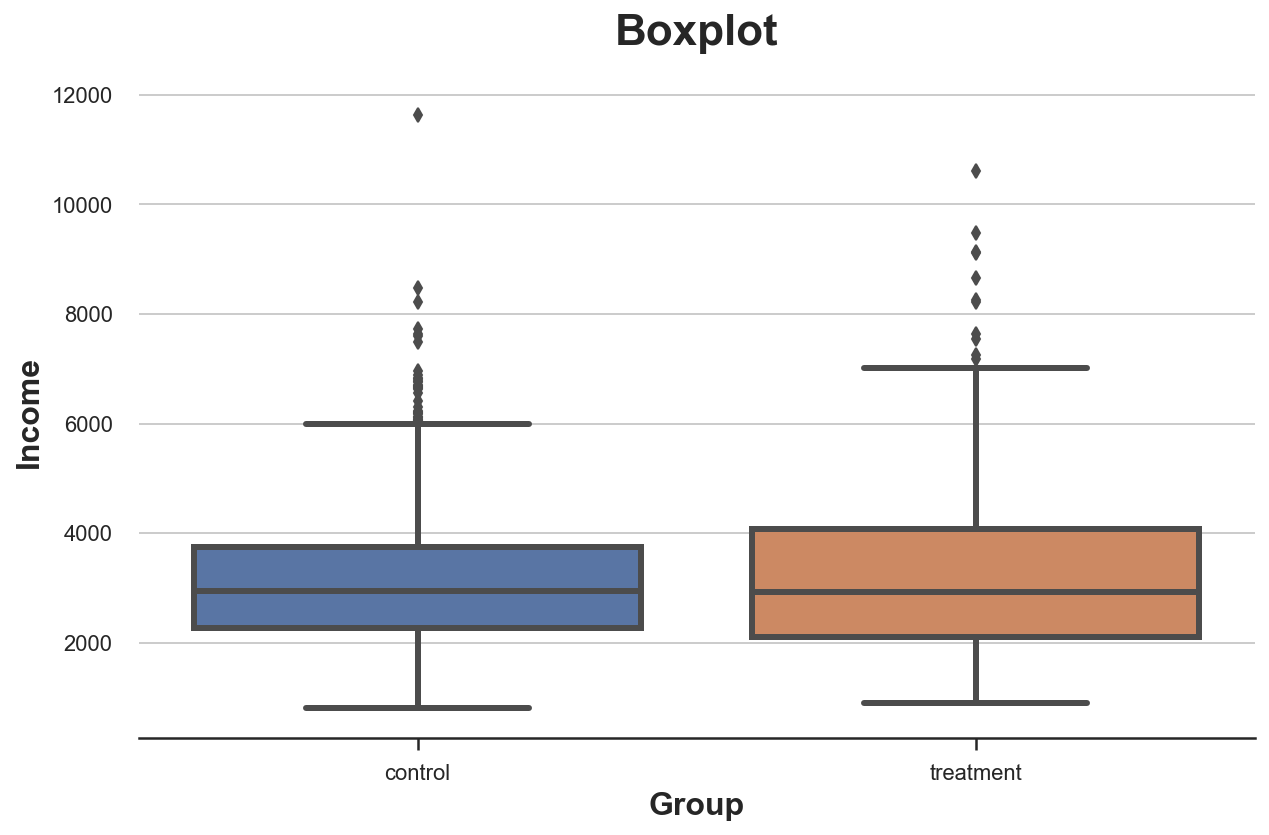

In [3]:
sns.boxplot(x='Group', y='Income', data=df);
plt.title("Boxplot");

It seems that the `income` distribution in the `treatment` group is slightly more dispersed: the orange box is larger and its whiskers cover a longer range. However, the **issue** with the boxplot is that it hides the shape of the data, telling us some summary statistics but not showing us the actual data distribution.

### Histogram

The most intuitive way to plot a distribution is the **histogram**. The histogram groups the data into equally spaced **bins** and plots the number of observations within each bin.

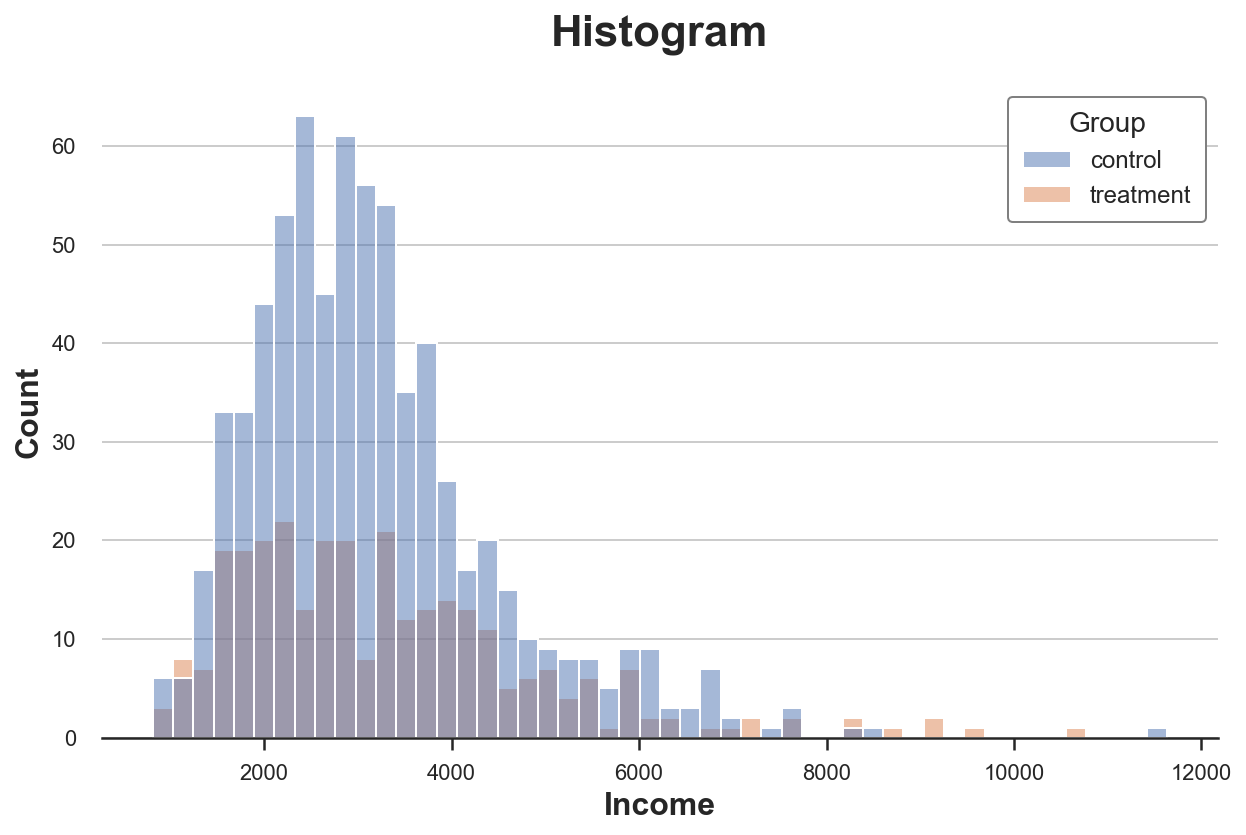

In [4]:
sns.histplot(x='Income', data=df, hue='Group', bins=50);
plt.title("Histogram");

There are multiple **issues** with this plot:

- The two histograms are not comparable: we would like a density, not a count
- The number of bins is arbitrary

We can solve the first issue using the `stat` option to plot the `density` instead of the count and setting the `common_norm` option to `False` to use the same normalization.

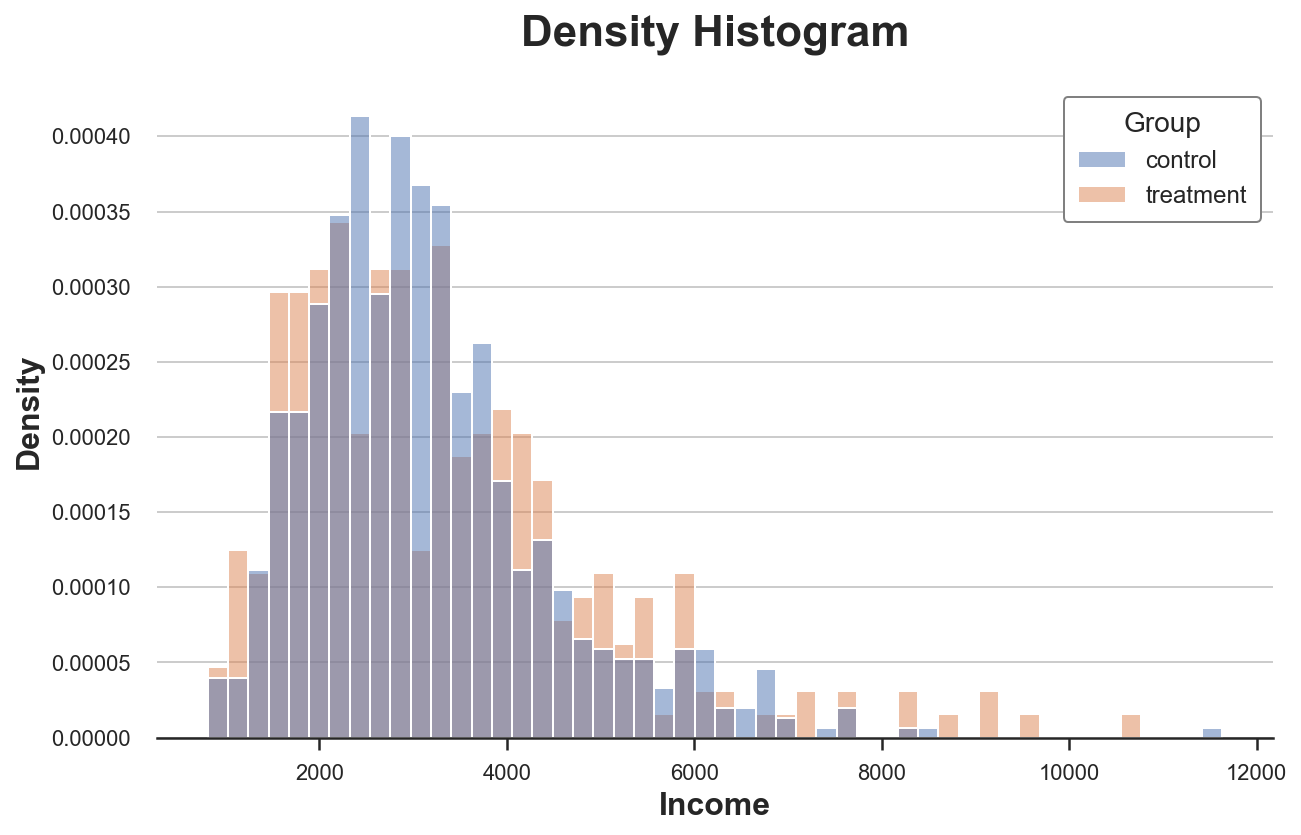

In [5]:
sns.histplot(x='Income', data=df, hue='Group', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

Now the two histograms are comparable!

However, an important **issue** remains: the size of the bins is arbitrary. If we bunch the data less, we end up with bins with one observation at most, if we bunch the data more, we lose information. This is a classical [bias-variance trade-off](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

### Kernel Density

One possible solution is to use a [**kernel density function**](https://en.wikipedia.org/wiki/Kernel_density_estimation) that tries to approximate the histogram with a continuous function, using [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation).

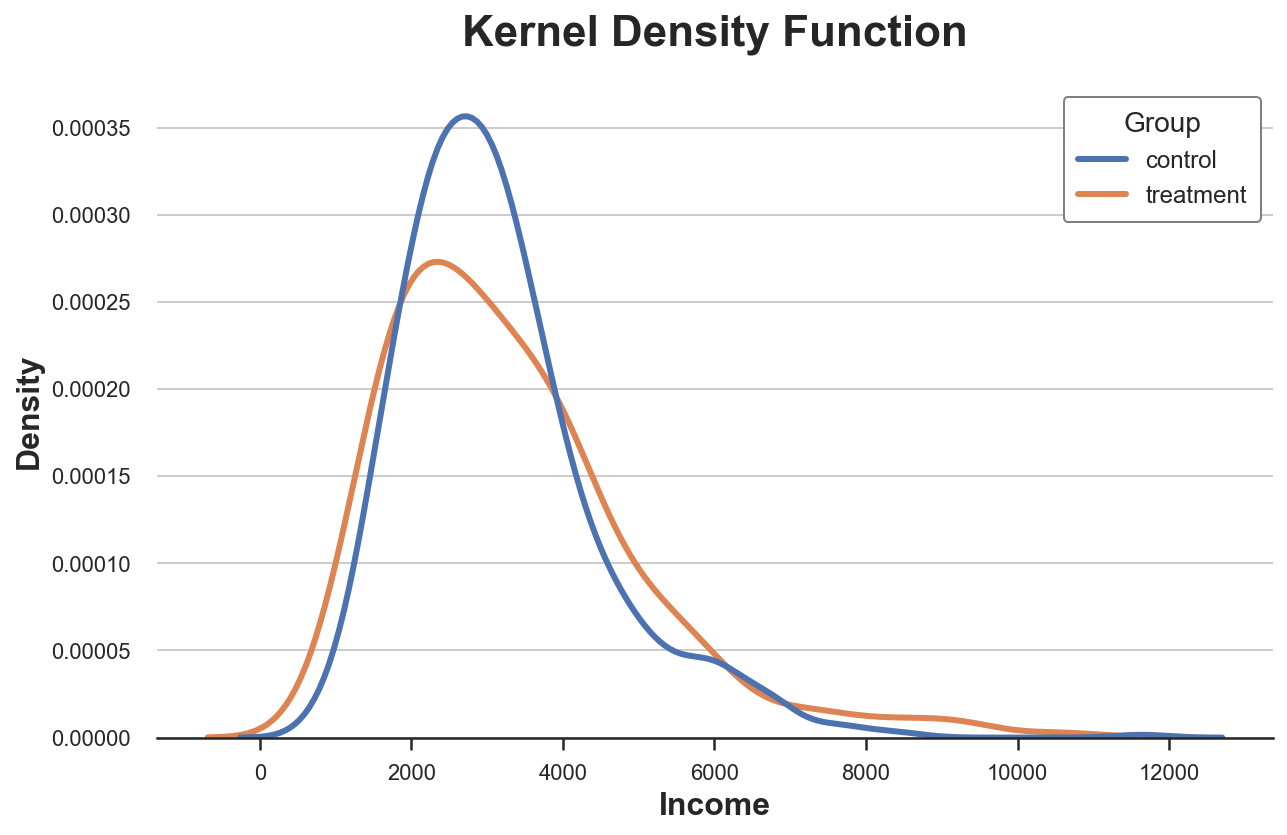

In [6]:
sns.kdeplot(x='Income', data=df, hue='Group', common_norm=False);
plt.title("Kernel Density Function");

From the plot, it seems that the estimated kernel density of `income` is very similar across treatment and control units.

However, the **issue** with kernel density estimation is that it is somehow a black-box and might mask relevant features of the data.

### Cumulative Distribution

A much more transparent representation of the two distribution is their [**cumulative distribution function**](https://en.wikipedia.org/wiki/Cumulative_distribution_function). At each point of the x axis (`income`) we plot the percentage of data points that have an equal or lower value. The main **advantages** of the cumulative distribution function are that

- we do not need to make any arbitrary choice (e.g. number of bins)
- we do not need to perform any approximation (e.g. with KDE)

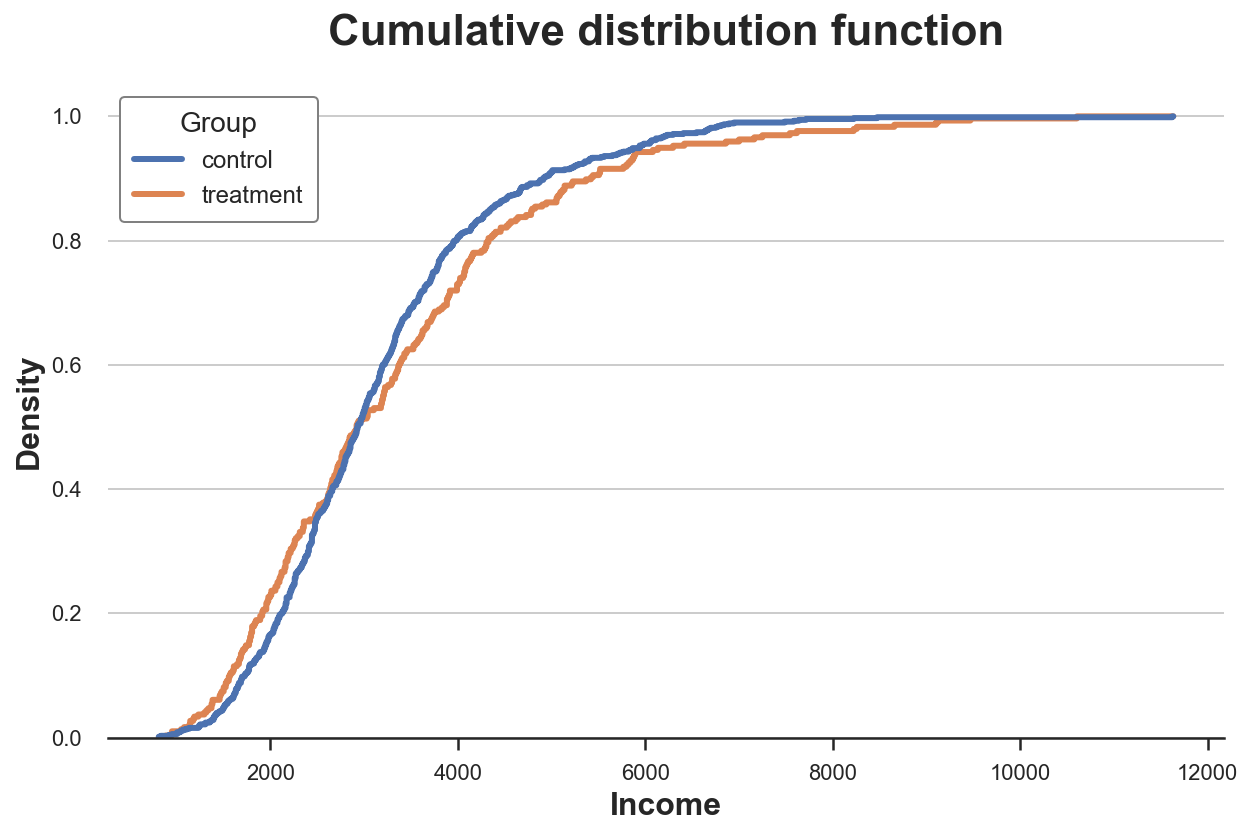

In [7]:
sns.histplot(x='Income', data=df, hue='Group', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

We can now clearly see that there are relatively more observations with low income in the treatment group than in the control group. In fact, the blue line is above the orange line on the right and below the orange line on the left.  

### QQ Plot

A related alternative method is the **qq-plot**, where *q* stands for quantile. The qq-plot plots the quantiles of the two distributions against each other. If the distributions are the same, we should get the 45 degree line.

There is no native qq-plot function in Python and, while the `statsmodels` package provides a [`qqplot` function](https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html), it is quite cumbersome. Therefore, we will do it by hand.

First, we need to compute the quartiles of the two groups, using the `percentile` function.

In [10]:
income = df['Income'].values
income_t = df.loc[df.Group=='treatment', 'Income'].values
income_c = df.loc[df.Group=='control', 'Income'].values

df_pct = pd.DataFrame()
df_pct['q_treatment'] = np.percentile(income_t, range(100))
df_pct['q_control'] = np.percentile(income_c, range(100))

Now we can plot the two quantile distributions against each other, plus the 45-degree line, representing the benchmark perfect fit.

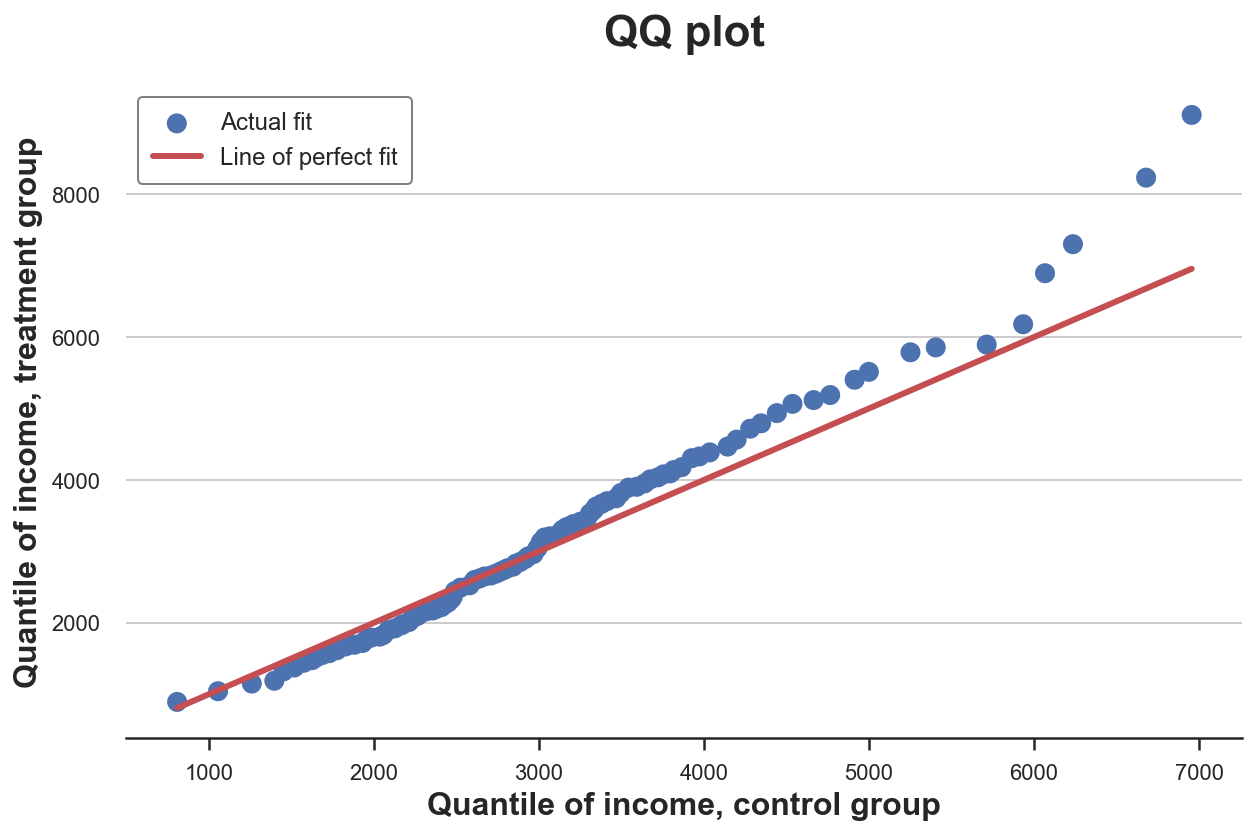

In [11]:
plt.scatter(x='q_control', y='q_treatment', data=df_pct, label='Actual fit');
sns.lineplot(x='q_control', y='q_control', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of income, control group')
plt.ylabel('Quantile of income, treatment group')
plt.legend()
plt.title("QQ plot");

The qq-plot delivers a very similar insight with respect to the cumulative distribution plot: income in the treatment group is generally lower.

## Two Groups - Tests

So far, we have seen different ways to visualize differences between distributions. The main advantage of visualization is **intuition**: we can eyeball the differences and intuitively assess them.

However, we might want to be more **rigorous** and try to assess the **statistical significance** of the difference between the distributions, i.e. answer the question "*is the observed difference systematic or due to sampling variation?*".

We are now going to analyze different tests to discern two distributions from each other. 

### T-test

The first and most common test is the [student t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). T-tests are generally used to **compare means**. In this case, we want to test whether the means of the `income` distribution is the same across the two groups. The test statistic for the two-means comparison test is given by:

$$
stat = \frac{|\bar x_1 - \bar x_2|}{\sqrt{s_1 / n_1 + s_2 / n_2}}
$$

Where $\bar x$ is the sample mean and $s$ is the sample standard deviation. Under mild conditions, the test statistic is asymptotically distributed as a [student t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution.

We use the `ttest_ind` function from `scipy` to perform the t-test. The function returns both the test statistic and the implied [p-value](https://en.wikipedia.org/wiki/P-value).

In [12]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(income_c, income_t)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=-1.3192, p-value=0.1874


In general, it is common practice to always perform this test on all variables, when we are running a randomized control trial or A/B test. The results of these tests are usually collected into a table that is called **balance table**.

We can use the [`create_table_one`](https://causalml.readthedocs.io/en/latest/causalml.html#module-causalml.match) function from the [`causalml`](https://causalml.readthedocs.io/en/latest/about.html) library to generate the balance table. As the name of the function suggests, the balance table should always be the **first table** you present when performing an A/B test.

In [16]:
from causalml.match import create_table_one

df['treatment'] = df['Group']=='treatment'
create_table_one(df, 'treatment', ['Gender', 'Age', 'Income'])

,Control,Treatment,SMD
Variable,,,
n,704,296,
Age,31.94 (8.53),35.88 (7.78),0.4822
Gender,0.51 (0.50),0.58 (0.49),0.1419
Income,3166.07 (1321.89),3296.32 (1645.58),0.0873


In the first two columns, we can see the average of the different variables across the treatment and control groups, with standard errors in parenthesis. In the **last column**, we have the p-values of the t-test for the null hypothesis of zero difference in means.

From the table, we observe that we cannot reject the null hypothesis of zero difference in mean for any variable, at the 95% confidence level.

### Chi-Squared Test

The [chi-squared test](https://matteocourthoud.github.io/post/chisquared/) is a very powerful test that can be used in many different settings. If you want to find out more about it, I have written a very comprehensive [blog post here](https://matteocourthoud.github.io/post/chisquared/).

One of the **least known applications** of the chi-squared test, is testing the similarity between two distributions. The **idea** is to bin the observations of the two groups. If the two distributions were the same, we would expect the same frequency of observations in each bin. Importantly, we need enough observations in each bin, in order for the test to be valid. I generate bins corresponding to deciles of the distribution of `income` in the control group. 

In [17]:
df_bins = pd.DataFrame()
_, bins = pd.qcut(income_c, q=10, retbins=True)
df_bins['bin'] = pd.cut(income_c, bins=bins).value_counts().index
df_bins['income_c'] = pd.cut(income_c, bins=bins).value_counts().values
df_bins['income_t'] = pd.cut(income_t, bins=bins).value_counts().values

df_bins

,bin,income_c,income_t
0,"(808.96, 1730.77]",70,42
1,"(1730.77, 2127.948]",70,36
2,"(2127.948, 2411.451]",70,25
3,"(2411.451, 2670.312]",71,20
4,"(2670.312, 2935.05]",70,26
5,"(2935.05, 3208.662]",70,13
6,"(3208.662, 3542.805]",71,25
7,"(3542.805, 3972.996]",70,26
8,"(3972.996, 4912.782]",70,41
9,"(4912.782, 11634.39]",71,42


We can now perform the test by comparing the frequencies of the two distributions, across bins. The test statistic is given by:

$$
stat = \sum _{i=1}^{n} \frac{(O_i - E_i)^{2}}{E_i}
$$

Where the bins are indexed by $i$ and $O$ is the observed number of data points in bin $i$ and $E$ is the expected number of data points in bin $i$. Since we generated the bins using deciles of the distribution of `income` in the control group, we expect the number of observations per bin in the treatment group to be the same across bins. Under mild assumptions, the test statistic is asymptocally distributed as a [chi-squared](https://en.wikipedia.org/wiki/Chi-squared_distribution) distribution. 

To compute the test statistic and the p-value of the test, we use the `chisquare` function from `scipy`.

In [18]:
from scipy.stats import chisquare

df_bins['income_t_norm'] = df_bins['income_t'] / np.sum(df_bins['income_t']) * np.sum(df_bins['income_c'])
stat, p_value = chisquare(df_bins['income_c'], df_bins['income_t_norm'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=95.2526, p-value=0.0000


The p-value is practically zero, implying that we reject the null hypothesis of no difference between the two distributions.

### Kolmogorov-Smirnov Test

The idea of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), is to **compare the cumulative distributions** of the two groups. In particular, the Kolmogorov-Smirnov test statistic is the maximum absolute difference between the two cumulative distributions.

$$
stat = \sup _{x} \ \Big| \ F_1(x) - F_2(x) \ \Big|
$$

Where $F_1$ and $F_2$ are the two cumulative distribution functions and $x$ are the values of the underlying variable. Under mild conditions, the asymptotic distribution of the Kolmogorov-Smirnov test statistic is known.

To better understand the test, let's plot the cumulative distribution functions and the test statistic. First, we compute the cumulative distribution functions.

In [19]:
df_ks = pd.DataFrame()
df_ks['Income'] = np.sort(df['Income'].unique())
df_ks['F_control'] = df_ks['Income'].apply(lambda x: np.mean(income_c<=x))
df_ks['F_treatment'] = df_ks['Income'].apply(lambda x: np.mean(income_t<=x))
df_ks.head()

,Income,F_control,F_treatment
0,808.96,0.001420,0.000000
1,831.93,0.002841,0.000000
2,893.28,0.002841,0.003378
3,925.08,0.004261,0.003378
4,951.21,0.004261,0.006757


We now need to find the point where the absolute distance between the cumulative distribution functions is largest.

In [20]:
k = np.argmax( np.abs(df_ks['F_control'] - df_ks['F_treatment']))
tstat = np.abs(df_ks['F_treatment'][k] - df_ks['F_control'][k])

We can visualize the value of the test statistic, by plotting the two cumulative distribution functions and the value of the test statistic.

ValueError: x and y must have same first dimension, but have shapes (1,) and (999,)

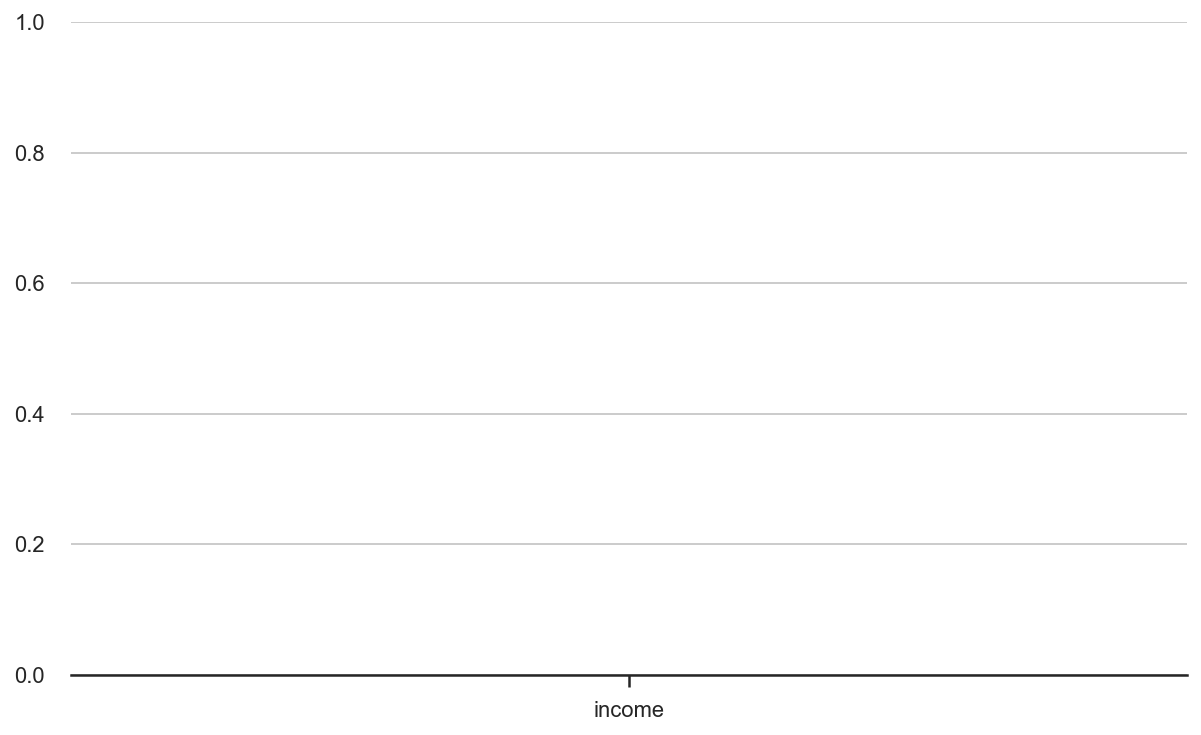

In [21]:
y = (df_ks['F_treatment'][k] + df_ks['F_control'][k])/2
plt.plot('income', 'F_control', data=df_ks, label='Control')
plt.plot('income', 'F_treatment', data=df_ks, label='Treatment')
plt.errorbar(x=df_ks['Income'][k], y=y, yerr=tstat/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {tstat:.4f}")
plt.legend(loc='center right');
plt.title("Kolmogorov-Smirnov Test");

From the plot, we can see that the value of the test statistic corresponds to the distance between the two cumulative distributions at `income`=4000. For that value of `income`, we have the largest imbalance between the two groups.

We can now perform the actual test using the `kstest` function from `scipy`.

In [ ]:
from scipy.stats import kstest

stat, p_value = kstest(income_t, income_c)
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

The p-value is still above 5%: we do not reject the null hypothesis that the two distributions are the same, with 95% confidence.

### Permutation Tests

A non-parametric alternative is permutation testing. The idea is that, under the null hypothesis, the two distributions should be the same, therefore **shuffling** the group labels should not significantly alter any statistic.

We can then chose any statistic and compute how much more extreme it is for different permutations, with respect to its value in the original sample. For example, let's use as a test statistic difference of **sample mean** between the treatment and control group. 

In [22]:
sample_stat = np.mean(income_t) - np.mean(income_c)

In [23]:
K = 1000
stats = np.zeros(1000)
labels = (df['Group'] == 'treatment').values
for k in range(K):
    np.random.shuffle(labels)
    stats[k] = np.mean(income[labels]) - np.mean(income[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation test: p-value={p_value:.4f}")

Permutation test: p-value=0.0910


The permutation test gives us a p-value very similar to the ones obtained with the other tests. 

How do we **interpret** the p-value? It means that he sample mean of the treatment group in the data is larger than $1 - 0.082 = 91.8\%$ of the sample means of the treatment group across the permuted samples. 

We can **visualize** the test, by plotting the distribution of the test statistics against its sample value.

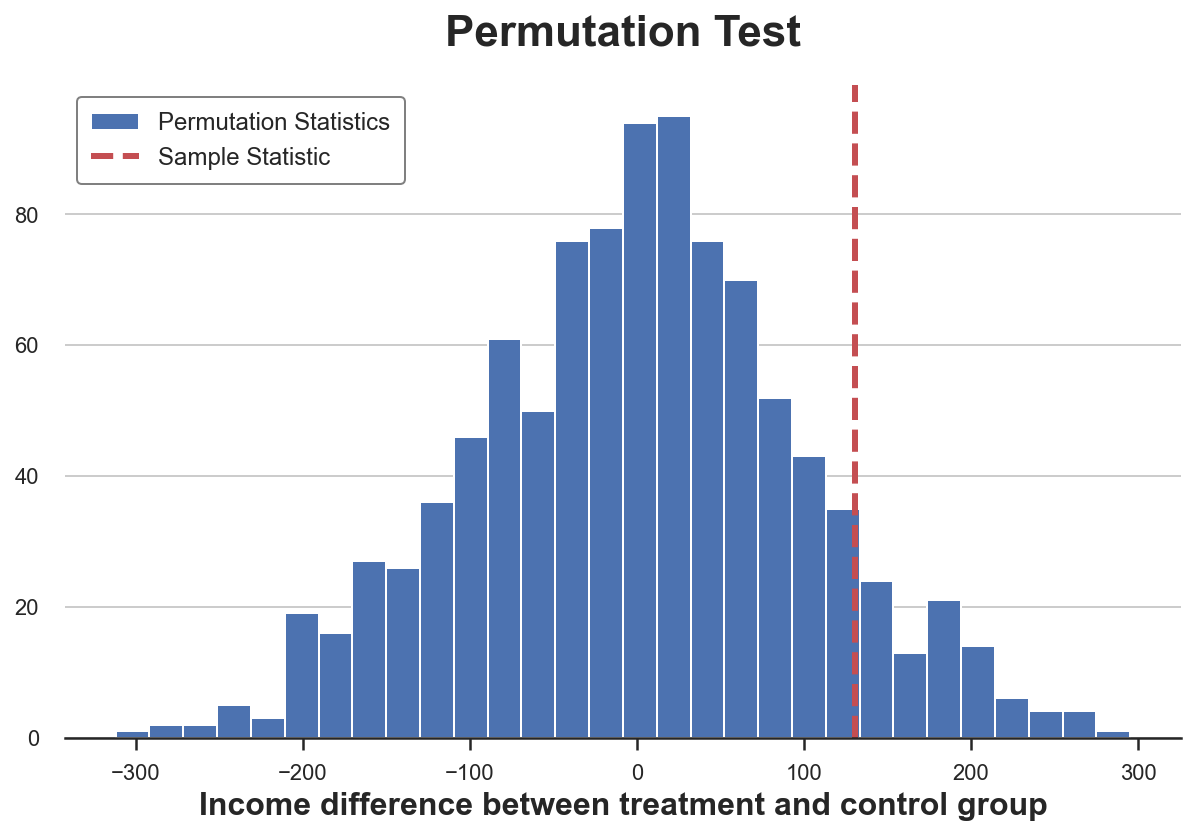

In [24]:
plt.hist(stats, label='Permutation Statistics', bins=30);
plt.axvline(x=sample_stat, c='r', ls='--', label='Sample Statistic');
plt.legend();
plt.xlabel('Income difference between treatment and control group')
plt.title('Permutation Test');

As we can see, the sample statistic is quite extreme with respect to the values in the permuted samples, but not excessively.

## Multiple Groups - Plots

So far we have only considered the case of two groups: treatment and control. But that if we had multiple groups? Some of the methods we have seen above scale well, while others don't.

### Boxplot

The **boxplot** scales very well, when we have a number of groups in the single-digits.

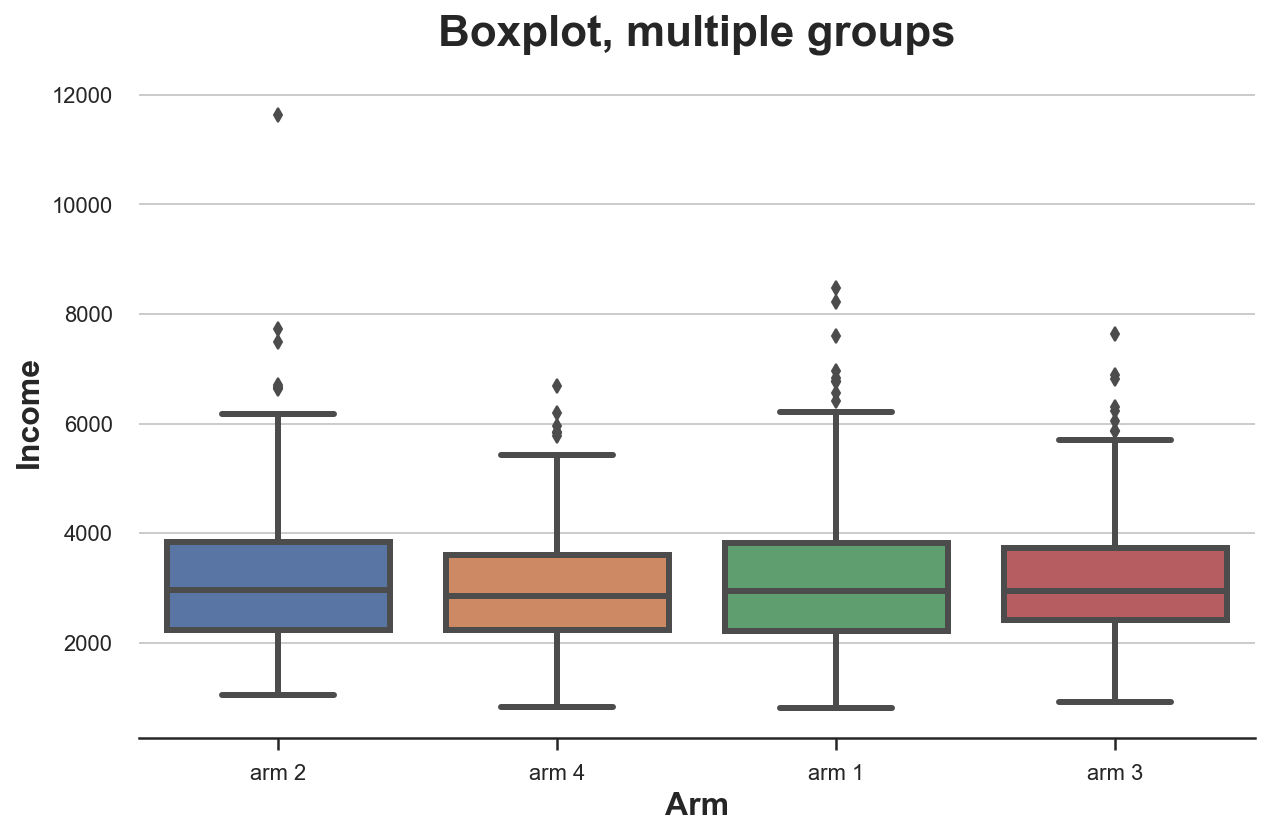

In [25]:
sns.boxplot(x='Arm', y='Income', data=df);
plt.title("Boxplot, multiple groups");

From the plot, it looks like the distribution of `income` across treatment arms is quite comparable.

### Violin Plot

A very nice extension of the boxplot that combines summary statistics and kernel density estimation is the  **violinplot**. The violinplot plots separate densities along the y axis so that they don't overlap. By default, it also adds a miniature boxplot inside. 

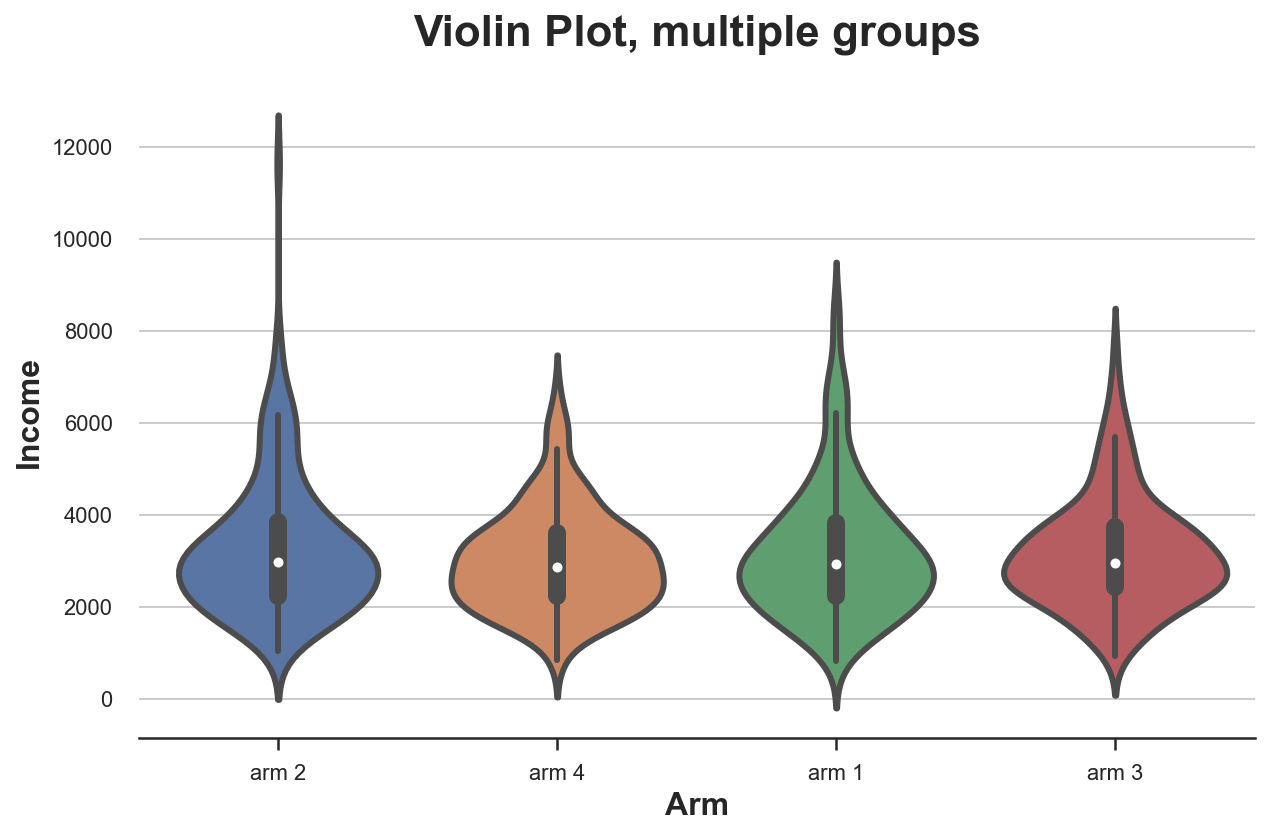

In [26]:
sns.violinplot(x='Arm', y='Income', data=df);
plt.title("Violin Plot, multiple groups");

## Multiple Groups - Tests

### F-test

With multiple groups, the most popular test is the [**F-test**](https://en.wikipedia.org/wiki/F-test). The F-test compares the variance of a variable across different groups. This analysis is also called analysis of variance, or **ANOVA**.

In practice, the F-test statistic is

$$
\text{f-stat} = \frac{\text{between-group variance}}{\text{within-group variance}} = \frac{\sum_{g} \big( \bar X_g - \bar X \big) / (G-1)}{\sum_{g} \sum_{i \in g} \big( \bar X_i - \bar X_g \big) / (N-G)}
$$

Where $G$ is the number of groups and $N$ is the number of observations. Under the null hypothesis of group independence, the f-statistic has an [**F-distribution**](https://en.wikipedia.org/wiki/F-distribution).

In [27]:
from scipy.stats import f_oneway

income_groups = [df.loc[df['Arm']==arm, 'Income'].values for arm in df['Arm'].dropna().unique()]
stat, p_value = f_oneway(*income_groups)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=1.2127, p-value=0.3041


The p-value is larger than 0.1, so we cannot reject the null hypothesis of no difference across groups, at any sensible significance level.

## Conclusion

TBD

### Related Articles

- [Goodbye Scatterplot, Welcome Binned Scatterplot](https://towardsdatascience.com/b63dc69e3d8c)
- [Chi-Square Distribution]()

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/distr.ipynb